<b>Изучение поведения пользователей приложения по продаже продуктов питания</b>

Целью исследования является изучение поведения пользователей для того, чтобы выявить, на каких шагах пользователи "отваливаются", а также исследовать необходимость изменения шрифта на основании проведенного A/A/B-тестирования.

Необходимо разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания. 

Для этого мы сначала изучим воронку продаж, чтобы понять каким путем и в каком количестве пользователи доходят до покупки.

После этого исследуем результаты A/A/B-эксперимента по изменению шрифта во всем приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие. 
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math as mth

### Откроем файл с данными и изучим общую информацию

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = "\s+")
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


### Подготовим данные

Переведем названия столбцов в нижний змеиный регистр, чтобы было красиво и понятно:

In [54]:
data.columns = data.columns.str.lower()
data = (data
        .rename(columns={'eventname':'event_name', 'deviceidhash':'device_id_hash', 'eventtimestamp': 'event_ts', 'expid': 'exp_id'})
       )
data.head()

,event_name,device_id_hash,event_ts,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим строки на явные дубликаты:

In [4]:
data.duplicated().sum()

413

Выявили 413 абсолютных дубликата. Их необходимо удалить.

In [5]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Проверим данные на отсутствующие значения:

In [6]:
data.isna().sum()

event_name        0
device_id_hash    0
event_ts          0
exp_id            0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_name      243713 non-null  object
 1   device_id_hash  243713 non-null  int64 
 2   event_ts        243713 non-null  int64 
 3   exp_id          243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


Изменим тип данных в столбце с датой и временем:

In [8]:
data['event_ts'] = pd.to_datetime(data['event_ts'], unit='s')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   device_id_hash  243713 non-null  int64         
 2   event_ts        243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [10]:
data.head()

,event_name,device_id_hash,event_ts,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Добавим столбец с датой:

In [11]:
data['event_date'] = data['event_ts'].dt.date

In [55]:
data.head()

,event_name,device_id_hash,event_ts,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Изучим и проверим данные

Посмотрим сколько всего событий в логе:

In [13]:
data.shape

(243713, 5)

Сколько всего пользователей в логе:

In [14]:
users_count = data[['device_id_hash']].value_counts().count()
users_count

7551

Сколько в среднем событий приходится на пользователя:

In [15]:
avg_event_per_user = int(len(data)) / users_count
avg_event_per_user

32.27559263673685

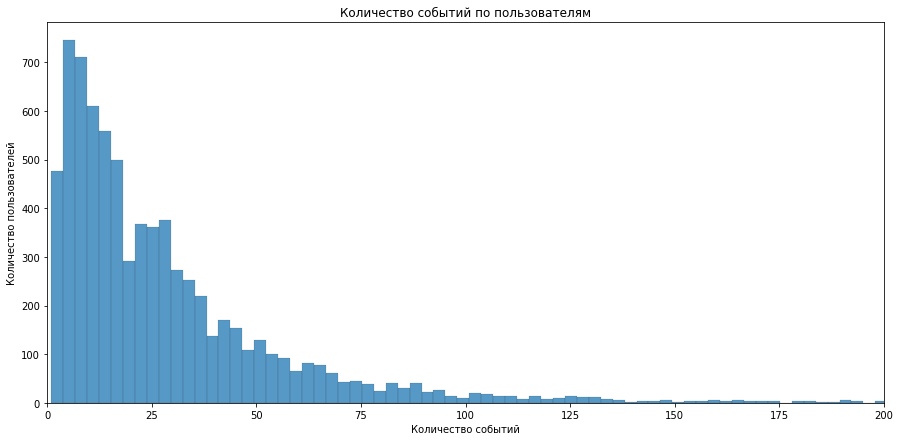

In [16]:
plt.figure(figsize=(15, 7))
sns.histplot(data=data.groupby('device_id_hash')[['event_name']].count(), x='event_name')
plt.title('Количество событий по пользователям')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.xlim(0, 200)
plt.show()

In [17]:
data['device_id_hash'].value_counts().describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
5%          3.000000
25%         9.000000
50%        20.000000
75%        37.000000
95%        89.000000
99%       200.500000
max      2307.000000
Name: device_id_hash, dtype: float64

Видим, что среднее количество событий на пользователя - 32, а медианное - 20. При этом, только 1% пользователей совершило больше 200 событий. Максимальное количество событий - 2307, слишком большое значение, которое перетянуло на себя такую разницу среднего от медианы.

За какой период у нас данные:

In [18]:
data['event_date'].min()

datetime.date(2019, 7, 25)

In [19]:
data['event_date'].max()

datetime.date(2019, 8, 7)

Мы располагаем данными за период с 25 июля 2019 по 7 августа 2019 года.

Построим гистограмму по дате и времени:

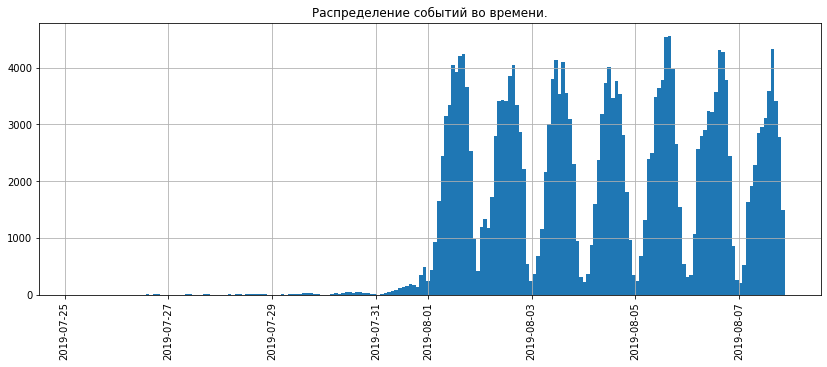

In [20]:
data['event_ts'].hist(bins=200, figsize=(14, 5)).set_title('Распределение событий во времени.')
plt.xticks(rotation='vertical');

По гистограмме видно, что основная часть данных сконцентрирована в период с 1 августа, что дает понять, что какие-то существенные изменения были внесены с этого момента, а данные с 25 июля по 1 августа являются хвостами из прошлого, которые необходимо отбросить.

In [21]:
data_full = data.query('event_ts > "2019, 8, 1"')
data_full

,event_name,device_id_hash,event_ts,exp_id,event_date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


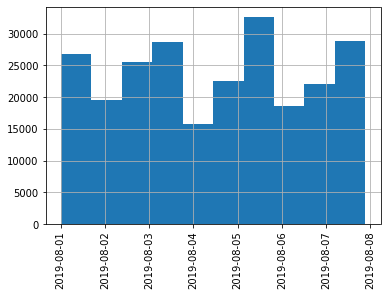

In [22]:
data_full['event_ts'].hist()
plt.xticks(rotation='vertical');

Посмотрим на долю событий в оставшемся периоде:

In [23]:
ratio_users_full = f'{(len(data_full) / len(data)):.2%}'
ratio_users_full

'98.84%'

Посчитаем количество пользователей в оставшемся периоде:

In [24]:
print(f'Всего пользователей осталось: {len(data_full.device_id_hash.unique())}.')

Всего пользователей осталось: 7534.


In [25]:
data_full.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Мы видим, что в оставшийся период попадает 98,43% всех событий, а так же остались 7530 пользователей из 7551 - это почти 99,7%, то есть потерянных пользователей меньше 1%, потерянных событий - чуть больше 1%. Оставшиеся пользователи присутствуют во всех трех экспериментальных группах, размеры групп примерно одинаковы.

Проверим, остались ли у нас пользователи во всех трех экспериментальных группах:

In [26]:
data_full['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Да, пользователей во всех трех группах примерно одинаковое количество.

### Изучим воронку событий

Для начала проверим, нет ли пользователей, которые попали одновременно в несколько групп:

In [27]:
len(data_full.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1'))

0

Видим, что встречающихся в нескольких группах пользователей нет.

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте и уникальным пользователям.

In [28]:
data_full['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Посмотрим на популярность событий и количество пользователей.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.

In [29]:
events = (data_full
          .groupby('event_name')['device_id_hash']
          .agg(['count', 'nunique'])
          .reset_index()
         )
events.columns =['event_name', 'events_count', 'users_unique']
events = events.sort_values('users_unique', ascending = False)
events

,event_name,events_count,users_unique
1,MainScreenAppear,117328,7419
2,OffersScreenAppear,46333,4593
0,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


Самое популярное событие - это просмотр главного экрана. Затем примерно одинаковое количество у события "Появление экрана предложений" и "Появление экрана с корзиной". Руководство просматривают меньше всего и то, скорее всего, случайно)

In [30]:
#users = data_full.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values('device_id_hash', ascending = False)
#users

Посчитаем долю пользователей, которые хоть раз совершали событие.

In [31]:
events['ratio_users'] = (events['users_unique'] / data.device_id_hash.nunique())
events.style.format({'ratio_users': '{:.2%}'})

,event_name,events_count,users_unique,ratio_users
1,MainScreenAppear,117328,7419,98.25%
2,OffersScreenAppear,46333,4593,60.83%
0,CartScreenAppear,42303,3734,49.45%
3,PaymentScreenSuccessful,33918,3539,46.87%
4,Tutorial,1005,840,11.12%


При загрузке приложения первое, что видит пользователь - это главный экран, поэтому 98% пользователей точно совершают это действие. Остальные 2% отваливаются из-за технических сбоев при загрузке приложения, или закрывают его, не дождавшись загрузки. Затем, перед покупкой, пользователь хочет ознакомиться со всеми предложениями, как я понимаю: это каталог. Логично, чтобы выбрать товар нужно ознакомиться с каталогом. Поэтому 60% пользователей заходят на этот экран, но почему-то достаточно большой процент не доходит до него. Этот вопрос я бы отдала в отдел тестирования после детального изучения отказов (с каких устройств и каких версий, например). Далее логичная и последовательная цепочка: корзина, страница успеха. С главной страницы до успеха доходят почти 47% пользователей. Про туториалы писала выше - это никак не вписывается в воронку и можно просматривать в любое время. Поэтому предлагаю его удалить:

<div id='link'></div>

In [32]:
events_funnel = events.query('event_name != "Tutorial"')
events_funnel.style.format({'ratio_users': '{:.2%}'})

,event_name,events_count,users_unique,ratio_users
1,MainScreenAppear,117328,7419,98.25%
2,OffersScreenAppear,46333,4593,60.83%
0,CartScreenAppear,42303,3734,49.45%
3,PaymentScreenSuccessful,33918,3539,46.87%


In [33]:
data_full = data_full.query('event_name != "Tutorial"')

Построим воронку событий:

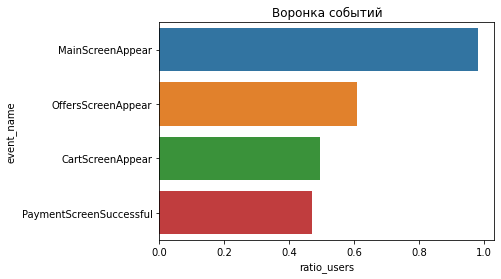

In [34]:
ax = sns.barplot(x = 'ratio_users', y = 'event_name', data = events_funnel.reset_index())
ax.set_title('Воронка событий');

Теперь разделим эту воронку по нашим испытательным группам:

In [35]:
event_pivot = (data_full
               .pivot_table(index=['event_name','exp_id'], values='device_id_hash', aggfunc=['count', 'nunique'])
               .reset_index()
              )
event_pivot.columns= ['event_name','exp_id', 'events_count', 'users_unique']
event_pivot

,event_name,exp_id,events_count,users_unique
0,CartScreenAppear,246,14690,1266
1,CartScreenAppear,247,12434,1238
2,CartScreenAppear,248,15179,1230
3,MainScreenAppear,246,37676,2450
4,MainScreenAppear,247,39090,2476
5,MainScreenAppear,248,40562,2493
6,OffersScreenAppear,246,14767,1542
7,OffersScreenAppear,247,15179,1520
8,OffersScreenAppear,248,16387,1531
9,PaymentScreenSuccessful,246,11852,1200


Построим воронку и подпишем в каждой группе количество пользователей:

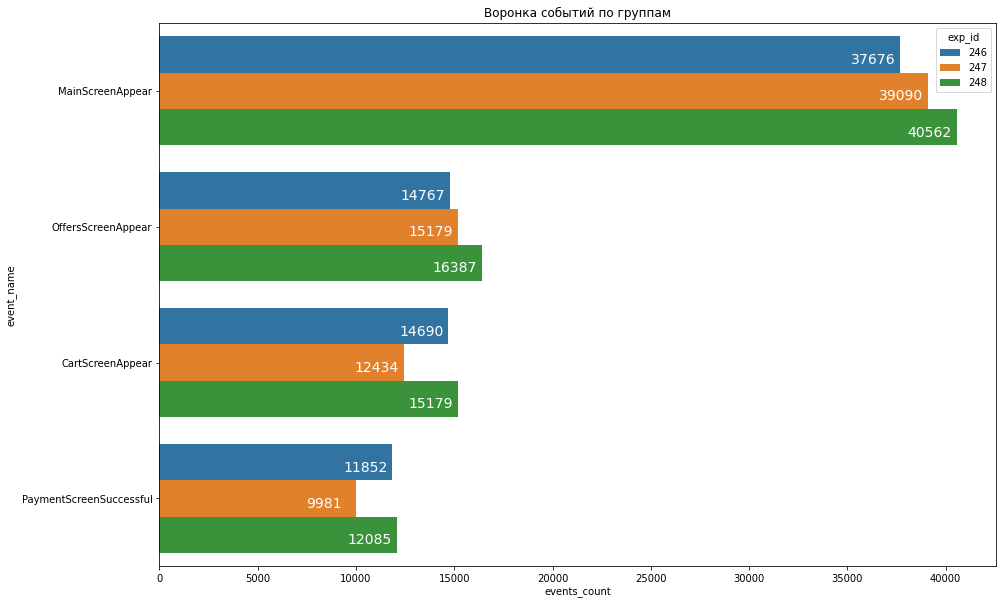

In [36]:
plt.figure(figsize = (15, 10))
sorting = events.query('event_name != "Tutorial"').sort_values('events_count', ascending = False).reset_index(drop = True)['event_name']
ax = sns.barplot(y = 'event_name', x = 'events_count', order = sorting, hue = 'exp_id', data = event_pivot)
ax.set_title('Воронка событий по группам')
for i in ax.patches:
    if i.get_width() > 9000:
        ax.text(i.get_width()-2500, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=14, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=14, color='black')
plt.show()

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [37]:
(events_funnel
     .sort_values('users_unique', ascending=False)['users_unique']
     .pct_change()
     .abs()
     .map(lambda n: '{:,.2%}'.format(n))
     )

1      nan%
2    38.09%
0    18.70%
3     5.22%
Name: users_unique, dtype: object

In [38]:
#ab = round((events_funnel['users_unique'][1] / events_funnel['users_unique'][0]) * 100, 2)
#bc = round((events_funnel['users_unique'][2] / events_funnel['users_unique'][1]) * 100, 2)
#cd = round((events_funnel['users_unique'][3] / events_funnel['users_unique'][2]) * 100, 2)
#print(ab, bc, cd)

Видим, что больше всего пользователей (чуть больше 37%) теряются на этапе перехода с главной страницы на страницу просмотра каталога. От каталога до корзины не доходит 11,4%, от корзины до успешного платежа теряется примерно 2,6% пользователей.

### Изучим результаты эксперимента

Посмотрим еще раз, сколько пользователей в каждой экспериментальной группе:

In [39]:
users_group = data_full.groupby('exp_id')['device_id_hash'].agg(['count', 'nunique']).reset_index()
users_group.columns =['group', 'events_count', 'users_unique']
users_group

,group,events_count,users_unique
0,246,78985,2483
1,247,76684,2512
2,248,84213,2535


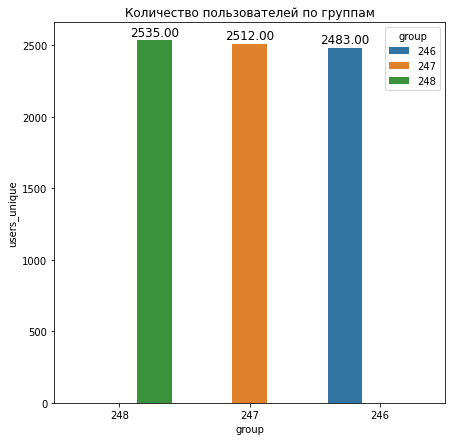

In [40]:
plt.figure(figsize = (7, 7))
sorting = users_group.sort_values('users_unique', ascending = False).reset_index(drop = True)['group']
ax = sns.barplot(y = 'users_unique', x = 'group', order = sorting, hue = 'group', data = users_group)
ax.set_title('Количество пользователей по группам')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

По таблице видно, что примерно одинаковое количество пользователей в каждой экспериментальной группе. Выделим и посмотрим подробнее, насколько различаются наши группы:

In [41]:
group_246 = data_full.query('exp_id == 246').groupby('exp_id')['device_id_hash'].nunique().reset_index()
group_247 = data_full.query('exp_id == 247').groupby('exp_id')['device_id_hash'].nunique().reset_index()
difference = 1 - group_246.iloc[0]['device_id_hash'] / group_247.iloc[0]['device_id_hash']
print('Разница между выборками 246 и 247 составляет {:.2%}'.format(difference))

Разница между выборками 246 и 247 составляет 1.15%


Теория гласит, что различие в количестве пользователей не должно превышать 1% для успешного A/A-теста. У нас превышение незначительное, поэтому считаем, что точность достаточная для проведения эксперимента. 

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Посмотрим сколько пользователей из каждой группы совершило каждое событие:

In [42]:
exp_table = (data_full
             .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
            )
exp_table

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181


Теперь для наглядности построим воронку пользователей по событиям, разделенную на группы:

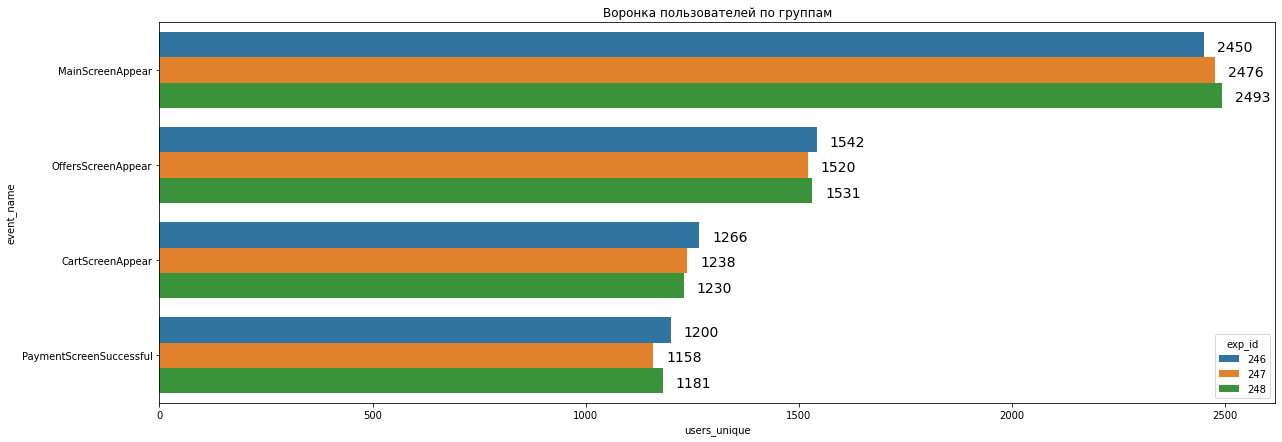

In [43]:
plt.figure(figsize = (20, 7))
sorting = (events
           .query('event_name != "Tutorial"')
           .sort_values('users_unique', ascending = False)
           .reset_index(drop = True)['event_name']
          )
ax = sns.barplot(y = 'event_name', x = 'users_unique', order = sorting, hue = 'exp_id', data = event_pivot)
ax.set_title('Воронка пользователей по группам')
for i in ax.patches:
    if i.get_width() > 9000:
        ax.text(i.get_width()-2500, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=14, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=14, color='black')
plt.show()

Самое популярное событие у пользователей всех групп - `MainScreenAppear`. 

Создадим функцию, которая поможет посчитать статистическую значимость между группами.

Определим критический уровень статистической значимости как 0,05.

Озвучим гипотезы:

H0: "Между экспериментальными группами нет статистически значимой разницы".

H1: "Между экспериментальными группами есть статистически значимая разница".

In [44]:
def ab_test(df, exp_groups, alpha):
    #найдем уникальных пользователей в каждой группе
    users = [df.query('exp_id == @group_number')['device_id_hash'].nunique() for group_number in exp_groups]
    #перебираем все экспериментальные группы для каждого события, считаем количество пользователей и долю
    for event in df.event_name.unique():
        events = [df.query('exp_id == %d and event_name == "%s"' % (group_number, event))['device_id_hash'].nunique() for group_number in exp_groups]
        # сравниваем кол-во уникальных юзеров на каждом шаге группы к кол-ву уникальных юзеров в этой группе всего
        p1 = events[0] / users[0] #считаем долю для 1 группы
        p2 = events[1] / users[1] #считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница в датасетах
        
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = st.norm(0, 1) #распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 #считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)
        #сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print('---')
        print(' ')

Посмотрим на события в 246 и 247 группах:

In [45]:
ab_test(data_full, [246, 247], 0.05)

MainScreenAppear
0.9867096254530809 0.9856687898089171
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.6210229561014902 0.6050955414012739
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.5098670962545309 0.4928343949044586
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4832863471606927 0.4609872611464968
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Различия между контрольными группами 246 и 247 статистически не значимы для всех событий. Можно сделать вывод, что разбиение на группы прошло верно и, поэтому, можно делать сравнение любой из этих групп с тестовой 248.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

Посмотрим на события в 246 и 248 группах:

In [46]:
ab_test(data_full, [246, 248], 0.05)

MainScreenAppear
0.9867096254530809 0.9834319526627219
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.6210229561014902 0.6039447731755424
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.5098670962545309 0.48520710059171596
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4832863471606927 0.4658777120315582
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Различия между группами 246 и 248 статистически не значимы для всех событий. Но мы видим, что p-value намного выше критерия значимости (0.05), что говорит о высокой вероятности различий между показателями, которые могли появиться случайно из-за выброса в данных или аномалий.

Посмотрим на события в 247 и 248 группах:

In [47]:
ab_test(data_full, [247, 248], 0.05)

MainScreenAppear
0.9856687898089171 0.9834319526627219
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.6050955414012739 0.6039447731755424
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.4928343949044586 0.48520710059171596
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4609872611464968 0.4658777120315582
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Схожая картина с предыдущим экспериментом, поэтому можно считать, что группы 247 и 248 не имеют различий.

Объединим две контрольные группы в одну:

In [48]:
group_merge = data_full.copy()
group_merge["exp_id"].replace({247: 246}, inplace = True)
group_merge["exp_id"].value_counts()

246    155669
248     84213
Name: exp_id, dtype: int64

In [49]:
group_merge["exp_id"] = group_merge["exp_id"].replace({246: 249})
group_merge["exp_id"].value_counts()

249    155669
248     84213
Name: exp_id, dtype: int64

Теперь посмотрим на события в объединенной контрольной группе 246 и 248 группах:

In [50]:
ab_test(group_merge, [249, 248], 0.05)

MainScreenAppear
0.9861861861861861 0.9834319526627219
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.613013013013013 0.6039447731755424
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.5013013013013013 0.48520710059171596
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4720720720720721 0.4658777120315582
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Различия между объединенной контрольной группой 249 и группой 248 статистически не значимы для всех событий. P-value больше alpha, откуда следует, что результат случаен, т.к. попадает в интервал 3 сигмы. Т.е. от 0.05 до 1.

<b>Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.</b>

Мы выбрали критический уровень статистической значимости alpha = 0.05.

Так как в нашем эксперименте 4 пары групп и 4 этапа в воронке, число гипотез равно 16. Для уменьшения вероятности ошибки первого рода (ложнопозтивного результата), которая увеличивается с каждой новой проверкой гипотезы в нашем множественном сравнении, необходимо применить поправку Бонферрони.

Для расчета поправки следует разделить наш уровень значимости (0,05) на число сравнений (16).

С учетом поправки, нашу alpha следовало бы уменьшить до: 0.05/16 = 0.003.

Теперь проверим те же гипотезы, но с уровнем значимости 0.003:

Смотрим на события в 246 и 248 группах:

In [51]:
ab_test(data_full, [246, 248], 0.003)

MainScreenAppear
0.9867096254530809 0.9834319526627219
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.6210229561014902 0.6039447731755424
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.5098670962545309 0.48520710059171596
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4832863471606927 0.4658777120315582
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Различия между 246 и 248 группами для всех событий статистически не значимы.

Смотрим на события в 247 и 248 группах:

In [52]:
ab_test(data_full, [247, 248], 0.003)

MainScreenAppear
0.9856687898089171 0.9834319526627219
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.6050955414012739 0.6039447731755424
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.4928343949044586 0.48520710059171596
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4609872611464968 0.4658777120315582
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Различия между 247 и 248 группами для всех событий статистически не значимы.

Теперь посмотрим на события в объединенной группе и группе 248:

In [53]:
ab_test(group_merge, [249, 248], 0.003)

MainScreenAppear
0.9861861861861861 0.9834319526627219
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
---
 
OffersScreenAppear
0.613013013013013 0.6039447731755424
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
---
 
CartScreenAppear
0.5013013013013013 0.48520710059171596
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
---
 
PaymentScreenSuccessful
0.4720720720720721 0.4658777120315582
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
---
 


Различия между объединенной группой 249 и 248 для всех событий статистически не значимы.

Все тесты превышают указанную поправку, поэтому у нас нет оснований отвергать нулевую гипотезу.

Вывод:

С учетом проделанных расчетов можно сделать вывод, что изменение шрифта сильно не повлияет на пользовательское поведение. А вот над главной страницей нужно поработать и выяснить, почему такой большой процент пользователей не идет дальше. Подробнее изучить устройства, с которых пользователи приходят, версию приложения, географию пользователя. Отделу тестирования посмотреть на баги, отделу UX/UI - на экспертизу.